# Statistics

Generate statistics from the `csv` files.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import datetime

In [152]:
openssl_dataframe = pandas.read_csv('../openssl_files/results_distinct.csv')
ssh_dataframe = pandas.read_csv('../result_files/results_ssh.csv')
tcp_dataframe = pandas.read_csv('../result_files/results_tcp.csv')

big_dataframe = pandas.concat([openssl_dataframe, ssh_dataframe, tcp_dataframe], join='inner')

## RQ1: Do SMT solvers scale in the state-based comparison of real-world models?


,reference version,updated version,incoming time,outgoing time,SMT solver
1,TCP_FreeBSD_Server,TCP_Linux_Server,0.007673,12.432911,msat
2,TCP_FreeBSD_Server,TCP_Linux_Server,0.046610,8.955984,msat
3,TCP_FreeBSD_Server,TCP_Linux_Server,0.007687,19.758183,msat
0,TCP_FreeBSD_Server,TCP_FreeBSD_Server,7.235037,6.770303,z3
4,TCP_FreeBSD_Server,TCP_Linux_Server,6.595164,7.940918,z3
5,TCP_Linux_Server,TCP_FreeBSD_Server,6.700082,8.649515,z3


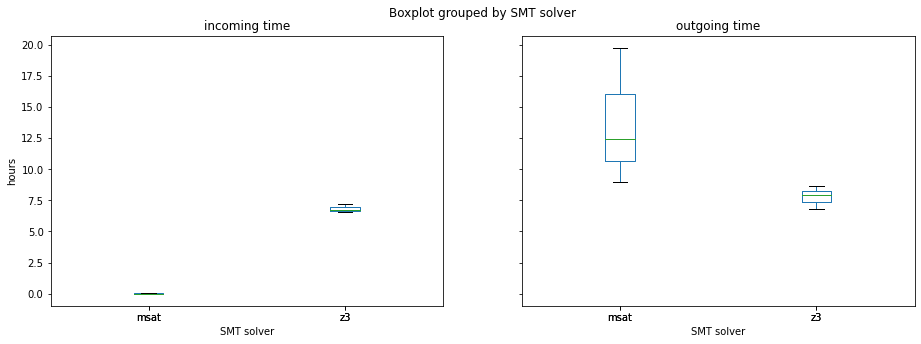

In [153]:
finish_time = datetime.timedelta(hours=6)

unfinshed = big_dataframe[(big_dataframe['incoming time'] >= finish_time.total_seconds()) | (big_dataframe['outgoing time'] >= finish_time.total_seconds())]
unfinshed = unfinshed.reset_index()
unfinshed = unfinshed[['reference version', 'updated version','incoming time' , 'outgoing time', 'SMT solver']]
unfinshed.update(pandas.DataFrame({ 'incoming time' : [ i/3600 for i in unfinshed['incoming time']]}))
unfinshed.update(pandas.DataFrame({ 'outgoing time' : [ i/3600 for i in unfinshed['outgoing time']]}))


display(unfinshed.sort_values('SMT solver'))
axs = unfinshed.boxplot(by='SMT solver', grid=False, figsize=(15,5))
axs[0].set_ylabel("hours")
axs[0].set_xlabel("SMT solver")
axs[1].set_xlabel("SMT solver")

None

## RQ2: Is one SMT solver superior to the other solvers?

## RQ3: Does the runtime of the solvers correlate to the size of the model changes?

### RQ3.1: Exection time vs number of state pairs

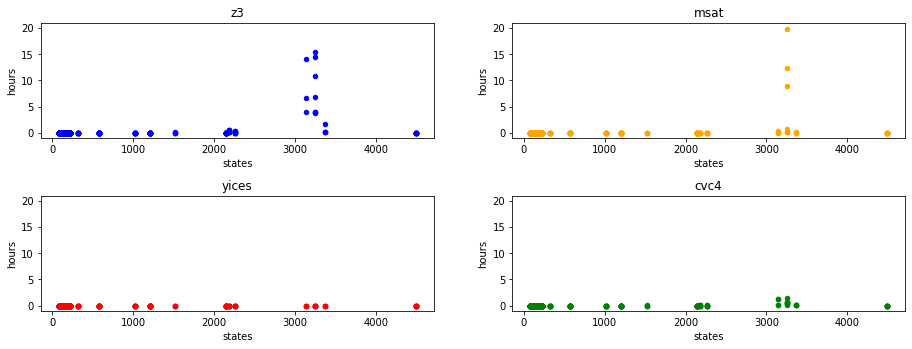

In [245]:
result_frame = big_dataframe[['SMT solver']]
result_frame.insert(1,"states",[i*j for i,j in zip(big_dataframe['reference model: number of states'], big_dataframe['updated model: number of states'])])
result_frame.insert(1,"hours",[(i+j)/3600 for i,j in zip(big_dataframe['incoming time'], big_dataframe['outgoing time'])])


fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15, 5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

result_frame[result_frame['SMT solver'] == 'z3'].plot.scatter("states", "hours", c="blue", subplots=True ,ax=axes[0,0])
axes[0,0].set_title("z3")

result_frame[result_frame['SMT solver'] == 'msat'].plot.scatter("states", "hours", c="orange", subplots=True ,ax=axes[0,1])
axes[0,1].set_title("msat")

result_frame[result_frame['SMT solver'] == 'yices'].plot.scatter("states", "hours", c="red", subplots=True ,ax=axes[1,0])
axes[1,0].set_title("yices")

result_frame[result_frame['SMT solver'] == 'cvc4'].plot.scatter("states", "hours", c="green", subplots=True ,ax=axes[1,1])
axes[1,1].set_title("cvc4")
for ax in axes.reshape(-1): 
    ax.set_ylim([-1, 21])




None

### RQ.2: Execution time vs performance metrics

## RQ4: How does the difference between models change during the evolution of a system?

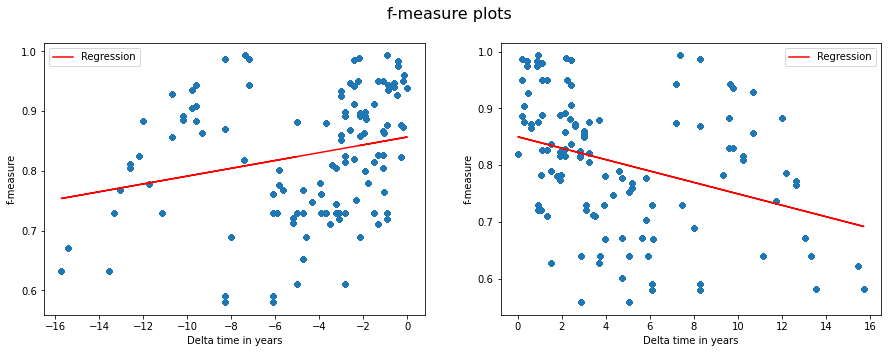

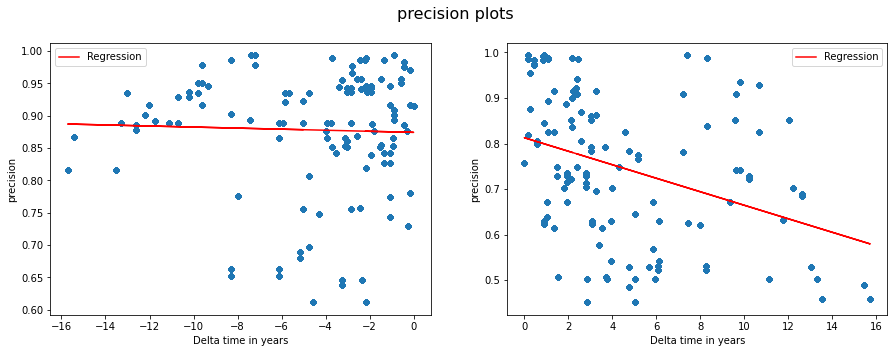

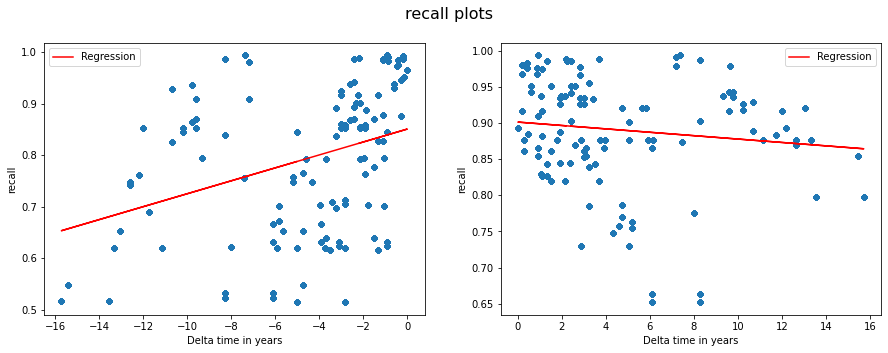

In [246]:
openssl_evolution = openssl_dataframe.copy()
openssl_evolution.update(pandas.DataFrame({'delta date (days)' : [ i/365 for i in openssl_evolution['delta date (days)']]}))
openssl_evolution = openssl_evolution[['delta date (days)', 'f-measure', 'precision', 'recall']]


def plot_regression(y_value):
    
    negative = openssl_evolution[openssl_evolution['delta date (days)'] < 0]
    positive = openssl_evolution[openssl_evolution['delta date (days)'] > 0]

    d = np.polyfit(negative['delta date (days)'],negative[y_value],1)
    f = np.poly1d(d)
    negative.insert(0,'Regression',f(negative['delta date (days)']))

    d = np.polyfit(positive['delta date (days)'],positive[y_value],1)
    f = np.poly1d(d)
    positive.insert(0,'Regression',f(positive['delta date (days)']))

    fig, axes = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(y_value + " plots", fontsize=16)
    
    negative.plot.scatter('delta date (days)', y_value, ax=axes[0], subplots=True)
    negative.plot(x='delta date (days)', y='Regression',color='Red',ax=axes[0])
    axes[0].set_xlabel("Delta time in years")

    axs = positive.plot.scatter('delta date (days)', y_value, ax=axes[1], subplots=True)
    positive.plot(x='delta date (days)', y='Regression',color='Red',ax=axes[1])
    axes[1].set_xlabel("Delta time in years")

plot_regression('f-measure')
plot_regression('precision')
plot_regression('recall')